Contrast modulations
====================

Multiprimary devices with good linearity, high resolution and rapid spectral switching capability may be used to present temporal modulations of photoreceptor-targeted contrast. Such stimuli have helped to shed light on how the pupil responds to input from different photoreceptors as a function of time (e.g., [Barrionuevo et al., 2016](https://jov.arvojournals.org/article.aspx?articleid=2565122); [Spitschan et al., 2014](https://www.pnas.org/doi/10.1073/pnas.1400942111)). 

To make contrast modulations, first define a stimulus profile with a sampling frequency in line with the switching capability of the stimulation device. In this case, its a 1 Hz sinusoid with 50 samples per cycle.


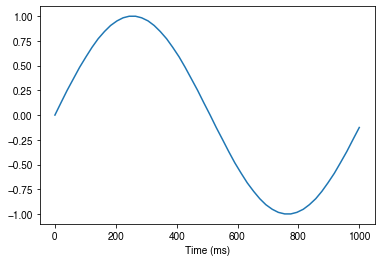

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sinusoid_modulation(f, duration, Fs=50):
    """Generate a sinusoidal waveform"""
    x = np.arange(duration * Fs)
    return np.sin(2 * np.pi * f * x / Fs)

stimulus_profile = sinusoid_modulation(1, 1)
time = np.linspace(0, 1000, 50).astype('int')

plt.plot(time, stimulus_profile)
plt.xlabel('Time (ms)');

Now, define a problem. Here we define the background spectrum as all primaries at half-max power so we can maximise bidirectional contrast. Then we say that we want to ignore rods, minimize contrast on M-cones, L-cones and melanopsin, and modulate the S-cones.

In [11]:
from pysilsub.problem import SilentSubstitutionProblem as SSP

# Load some example data for a 10-primary system
ssp = SSP.from_json('../../data/STLAB_1_York.json')

ssp.background = [.5] * ssp.nprimaries
ssp.ignore = ['R']
ssp.minimize = ['M', 'L', 'I']
ssp.modulate = ['S']
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ignoring: ['R']
Minimising: ['M', 'L', 'I']
Modulating: ['S']
Target contrast: None


Next, choose a peak contrast value that is known to be in gamut and solve for each point in the stimulus profile. The algebraic approach is well suited here as it guarantees a linear uni-directional scaling of the primaries and is less computationally expensive than optimisation. 

In [12]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

Plotting the forward projection of contrast for each solution in this case reveals a smooth S-cone modulation with little contrast splatter on the other photoreceptors.

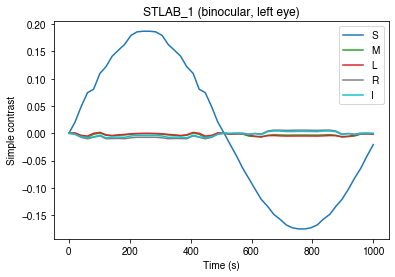

In [13]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

Finally, convert the solutions to settings compatible with the native resolution of the stimulation device.

In [22]:
device_settings = [ssp.weights_to_settings(s) for s in solutions]
device_settings = pd.DataFrame(device_settings, index=time)
with pd.option_context('display.max_rows', 10):
    print(device_settings)

         0     1     2     3     4     5     6     7     8     9
0     2047  2047  2047  2047  2047  2047  2047  2047  2047  2047
20    2031  1982  1977  1957  1978  2095  2216  2066  1972  2020
40    2015  1918  1908  1868  1910  2142  2382  2085  1898  1993
61    2000  1856  1841  1782  1844  2188  2543  2104  1826  1967
81    1985  1798  1777  1700  1781  2231  2696  2121  1758  1943
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
918   2122  2351  2376  2470  2371  1822  1255  1956  2400  2174
938   2109  2296  2317  2394  2313  1863  1398  1973  2336  2151
959   2094  2238  2253  2312  2250  1906  1551  1990  2268  2127
979   2079  2176  2186  2226  2184  1952  1712  2009  2196  2101
1000  2063  2112  2117  2137  2116  1999  1878  2028  2122  2074

[50 rows x 10 columns]


Now you just need to tell the stimulation device to set the primary inputs to these values at the specified timepoints and it will produce the S-cone modulation shown above. 

Note that with this method one can also modulate multiple photoreceptors together.

In [15]:
ssp.ignore = ['R']
ssp.minimize = ['I']
ssp.modulate = ['S', 'M', 'L']

In [16]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

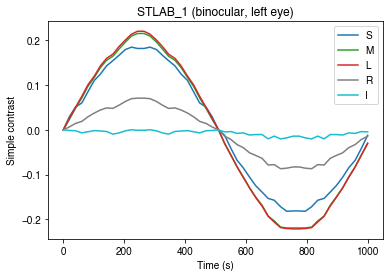

In [17]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

We can even modulate photoreceptors in counterphase.

In [18]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    c = point * peak_contrast
    ssp.target_contrast = [-c, c, c]
    solutions.append(ssp.linalg_solve())

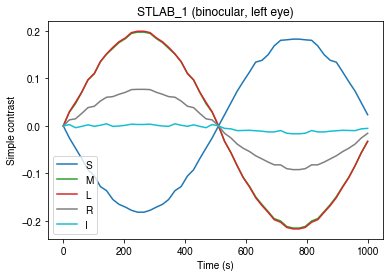

In [19]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();